## 2017314461 Muhammad Shakeel Zuhaib
Homework 9 (AI Porject)

NLP using character level LSTM

### Differences to Pytorch tutorial:
1) Removed duplicates from the dataset so that training and testing/evaluation have unique data.

2) Restricted the training data upto 70% of each category

3) Restricted the testing data upto the left 30% of each category

For more please check the comments in each cell

### Preprocessing the data, removing duplicates and shuffling:


In [80]:
#Downloading the data and unzipping it
!curl -LO https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

#Importing header files
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import numpy as np

def findFiles(path): return glob.glob(path)

#Find all files in this data/name directory with .txt extension
print(findFiles('data/names/*.txt'))

import unicodedata
import string

#Create an all_letters set: all upper case and lower case letter plus . , ; ' characters
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#Even though the names are romanized we should change them to ASCII
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Example of Unicode Characters converted to ASCII
print(unicodeToAscii('Ślusàrski'))


# Build the category_lines dictionary, a list of names per language
category_lines = {}  #the names/lines in each category (this is a dictionary (like a hashmap, you give it the category name it returns its names))
all_categories = []  #the 18 categories

# Read a file and split into lines
# this function returns all the lines/names under a specific category
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n') #split on new line token
    return [unicodeToAscii(line) for line in lines]


# Append the categories to all_categories and the lines to category lines
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] #category is equal to the file name
    all_categories.append(category) #add the category to all categories
    lines = readLines(filename) #add the names (lines)

    lines=list(set(lines)) # remove duplicates
    np.random.shuffle(lines) # shuffle indices

    category_lines[category] = lines #add the lines to the dictionary

n_categories = len(all_categories) # 18 categories

#Example Names
print(category_lines['Korean'][:5])
#All Categories
print(all_categories)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  17.0M      0 --:--:-- --:--:-- --:--:-- 17.0M
Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spa

### Changing the data to one-hot vectors:

In [81]:
import torch

#Note: the length of each vector = num of total unique letter (for example 26 english letters) and we set them to zero except that letter to 1

# Find letter index from all_letters, e.g. "a" = 0 , this index is the index of the hot vector to be set as one
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a letter into a <1 x n_letters> Tensor -> the hot_vector
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors  (each line /name -> converted to a 2d array of hot vectors)
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Test the previous functions:
print(letterToTensor('J')) # one simple hot vector
print(lineToTensor('Jones').shape) # length_of_word(sequence) X 1 X 57  -> the "1" is not important just think of it as a 2d matrix where the rows are the letters (hot vector)
print(lineToTensor('Jones')) #one hot vector for J, one for O, one for N, one for E, one for S

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

### Defining the Model/LSTM:

In [0]:
batch_size = 1
num_layers = 1
input_size = n_letters #size of the hot vector (remember we are just giving a single hot vector/single character to the network)
hidden_size = 128      #the output size of lstm (our choice)
output_size=n_categories #18 categories (final classification classes)
seq_length = 1 #we are using LSTM as an LSTM cell which takes a single character

import torch.nn as nn
  #we pass one character by one character and the input should be the size of batch*sequence*input_size(number_features)
  #note: seqeucne is the number of the letters that the input is depending on for example in HELLO ... the sequence is of size 5
class Model(nn.Module):
  def __init__(self):
      super(Model, self).__init__() 

      # LSTM Layer: It outputs the hidden state (here the layer is more like a cell)
      # Remember:
        # input_size: is a single character represented by the hot vector size
        # hidden_size: is our choice it is just an intermediate LSTM/RNN output size

      # The input should be of shape (seq_len, batch_size, input_size)
      # output1: outputs of shape (seq_len, batch, num_directions * hidden_size)
      # output2: h_n of shape (num_layers * num_directions, batch, hidden_size)
      # output3: c_n of shape (num_layers * num_directions, batch, hidden_size)
      self.lstm = nn.LSTM(input_size, hidden_size)
        

      # Fully connected layer: takes the hidden state and outputs a vector of size "output_size"
      # here the output is categories
      self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x,hidden,hidden2):
    
    x= x.view(seq_length, batch_size, input_size) #sequence, batch, size
        
    out, (h_n, c_n) = self.lstm(x, (hidden,hidden2))
        
    
    out=out.permute(1,0,2) # fully connected has always batch as the first dimension so flip 
    out = self.fc(out.view(batch_size,-1))
    out=  nn.functional.log_softmax(out,dim=1)
        
    return out, (h_n,c_n)

  # a function for initializing the h_n, c_n
  def initHidden(self):
    return torch.zeros(num_layers,batch_size, hidden_size)

### Driver Code:

In [89]:
lstm = Model() #model loading

input = letterToTensor('B')
hidden =lstm.initHidden()   #h_n
hidden2 =lstm.initHidden()  #c_n
output, (h_n,c_n) = lstm(input, hidden,hidden2)
print(output)


input = lineToTensor('Albert')
hidden =lstm.initHidden()   #h_n
hidden2 =lstm.initHidden()  #c_n
output,(h_n,c_n) = lstm(input[0], hidden,hidden2)
print(output)


tensor([[-2.9273, -2.8207, -2.8889, -2.9785, -2.9435, -2.8980, -2.8954, -2.8967,
         -2.8409, -2.8352, -2.8808, -2.9186, -2.8852, -2.9160, -2.8380, -2.8928,
         -2.9304, -2.8547]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9146, -2.8253, -2.8851, -2.9741, -2.9561, -2.9042, -2.9049, -2.9006,
         -2.8600, -2.8303, -2.9010, -2.9128, -2.8754, -2.9308, -2.8315, -2.8796,
         -2.9155, -2.8402]], grad_fn=<LogSoftmaxBackward>)


### Helper Functions + Data split:
80% Training - 20% Testing

In [90]:
# returns the category and its index based on the model output
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  #get the index of the greatest value
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

import random

#a very simple splitting technique
trainingMode=1 # if set to 1 the data will be retrieved from the first 80% indices of each category otherwise it will be retrieved from the other 20%

# pick a random element from a category: this function is modified to split data
def randomChoice(l):
  if trainingMode==1: # retrieve an element from the training set
    return l[random.randint(0, int(0.8*len(l))-1)]
  elif trainingMode==0: # retrieve an element from the testing set
    return l[random.randint(int(0.8*len(l)), len(l)-1)]

# pick a random category: no split needed
def randomChoiceCategory(l):
    return l[random.randint(0, len(l) - 1)]

# pick a random category and a random name from that category
def randomTrainingExample():
    category = randomChoiceCategory(all_categories) #choose a random category
    line = randomChoice(category_lines[category]) #choose a random name
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) #a tesnor indicating the category index
    line_tensor = lineToTensor(line) #change names to tensor / one hot vector array
    return category, line, category_tensor, line_tensor


# test the upper functions:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

('Italian', 1)
category = Vietnamese / line = To
category = Spanish / line = Amador
category = Spanish / line = Herrero
category = Korean / line = Rhee
category = Portuguese / line = Ferreiro
category = Italian / line = Durante
category = French / line = Guillory
category = Japanese / line = Munkata
category = Czech / line = Hanzlick
category = Arabic / line = Abadi


### Training Function: 

In [0]:
criterion = nn.NLLLoss()
learning_rate = 0.005

# This training function is for one name/line
def train(category_tensor, line_tensor):

    hidden = lstm.initHidden()
    hidden2 = lstm.initHidden()
    lstm.zero_grad()

    # Go through all name letters
    for i in range(line_tensor.size()[0]):
        output, (hidden,hidden2) = lstm(line_tensor[i], hidden,hidden2)

    # Calculate the loss and apply it backwards
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # This is for weight updates (similar to optimizer.step()) # backpropagation
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

### Training Function Driver:

In [104]:
import time
import math

n_iters = 150000
print_every = 5000
plot_every = 1000

trainingMode=1
if trainingMode==1:
  print("Using Training Set (80%) of all data")
else:
  print("Using Testing Set (20%) of all data")

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time() # start the clock

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample() # Get a random example (name)

    output, loss = train(category_tensor, line_tensor) # train for one name
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every) # the average loss per 1000 iter
        current_loss = 0


Using Training Set (80%) of all data
5000 3% (0m 23s) 0.1048 Cathan / Irish ✓
10000 6% (0m 46s) 3.8127 Leitzke / Polish ✗ (German)
15000 10% (1m 10s) 0.6130 Xuan / Chinese ✓
20000 13% (1m 33s) 3.5047 Maas / Arabic ✗ (Dutch)
25000 16% (1m 57s) 1.0386 Ritchie / Scottish ✓
30000 20% (2m 20s) 3.3700 Maas / Arabic ✗ (Dutch)
35000 23% (2m 43s) 0.5146 Magalhaes / Portuguese ✓
40000 26% (3m 7s) 1.8671 Del bosque / French ✗ (Spanish)
45000 30% (3m 30s) 0.9220 Levesque / French ✓
50000 33% (3m 53s) 1.0955 Quan / Vietnamese ✗ (Chinese)
55000 36% (4m 17s) 2.5278 Oberto / Spanish ✗ (Italian)
60000 40% (4m 40s) 0.4921 Klerken / Dutch ✓
65000 43% (5m 3s) 2.2141 Graham / Arabic ✗ (Scottish)
70000 46% (5m 27s) 0.3659 Kalb / Arabic ✓
75000 50% (5m 50s) 3.3040 Mas / Portuguese ✗ (Dutch)
80000 53% (6m 13s) 0.0399 Kyritsis / Greek ✓
85000 56% (6m 37s) 1.8855 Sleiman / Irish ✗ (Arabic)
90000 60% (7m 1s) 0.3065 Luong / Vietnamese ✓
95000 63% (7m 24s) 0.1474 Hodoval / Czech ✓
100000 66% (7m 48s) 2.4045 Meinha

### Plot the training average loss per 1000 iterations:

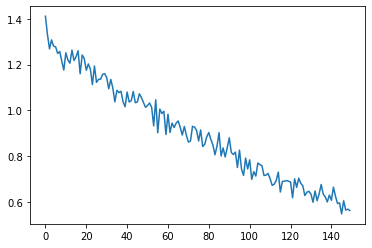

In [105]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing the model / Confusion matrix generation:
Evaluation is done on a new unused testing set

Using Testing Set (20%) of all data


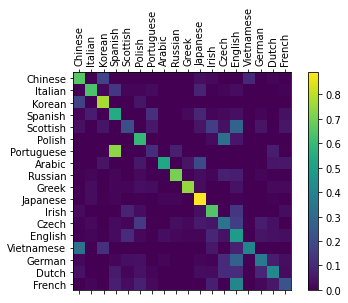

In [106]:
# Confusion Matrix: Rows are Categories | Columns are Guesses (this will show what are the guesses for each category)

# 18 by 18 zero initiialztion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

trainingMode=0 # choose data from the testing set
if trainingMode==1:
  print("Using Training Set (80%) of all data")
else:
  print("Using Testing Set (20%) of all data")

# Just evaluate without backpropagation
def evaluate(line_tensor):
    hidden = lstm.initHidden()
    hidden2 = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, (hidden,hidden2) = lstm(line_tensor[i], hidden,hidden2)

    return output

# Go through 10000 examples and record the result in the matrix
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Testing Accuracy:
Evaluation is done on a new unused testing set

In [110]:
# Driver code for the testing accuracy calculation:
trainingMode=0 # choose data from the testing set

if trainingMode==1:
  print("Using Training Set (80%) of all data")
else:
  print("Using Testing Set (20%) of all data")


iterations= 10000
correct_test=0
total_test=0

for i in range(iterations):
  category, line, category_tensor, line_tensor = randomTrainingExample() #get a sample

  with torch.no_grad():
    output = evaluate(line_tensor) #evaluate
  guess, guess_i = categoryFromOutput(output)

  if guess == category:
    correct_test+=1
  total_test+=1

print(correct_test/total_test)

Using Testing Set (20%) of all data
0.5162


### User Input Prediction:

In [111]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yazan')
predict('Laith')
predict('Dahab')


> Yazan
(-0.45) Arabic
(-1.53) Polish
(-3.06) Japanese

> Laith
(-1.02) Irish
(-1.51) English
(-1.71) Czech

> Dahab
(-0.00) Arabic
(-6.52) German
(-6.70) Russian
